# Movielens Dataset Temporal Analysis 

In [1]:
# Center All Plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Load Libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Configure

In [4]:
# Load Dataset
movies = pd.read_csv(r'C:/Users/Yukawa/datasets/ml-latest-small/movies.csv')
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [5]:
ratings = pd.read_csv(r'C:/Users/Yukawa/datasets/ml-latest-small/ratings.csv')
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [6]:
# Organise Ratings
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop= True)
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,517,1,4.0,1487954343
2,213,1,3.5,1316196157
3,514,1,4.0,1533872400
4,214,1,3.0,853937855
5,216,1,3.0,975211713
6,217,1,4.0,955942540
7,219,1,3.5,1194681084
8,509,1,4.0,1435992343
9,220,1,5.0,1230055565


In [7]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]
movies.head(10)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0
5,6,Heat,Action|Crime|Thriller,1995.0
6,7,Sabrina,Comedy|Romance,1995.0
7,8,Tom and Huck,Adventure|Children,1995.0
8,9,Sudden Death,Action,1995.0
9,10,GoldenEye,Action|Adventure|Thriller,1995.0


In [8]:
# Categorize movies genres properly. 
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [9]:
genres_unique = pd.DataFrame(genres_unique, columns=['genres']) # Format into DataFrame to store later
genres_unique

,genres
0,Adventure
1,Animation
2,Children
3,Comedy
4,Fantasy
5,Romance
6,Drama
7,Action
8,Crime
9,Thriller


In [10]:
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

In [11]:
# Modify rating timestamp format (from seconds to datetime year)

ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s', origin='unix')
ratings.timestamp = ratings.timestamp.dt.year
ratings.timestamp.head()

0    2000
1    2017
2    2011
3    2018
4    1997
Name: timestamp, dtype: int64

In [12]:
# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)

Number of movies Null values:  13
Number of ratings Null values:  0


##  Explore The Movielens Dataset

### 0. Number of Ratings Per Year

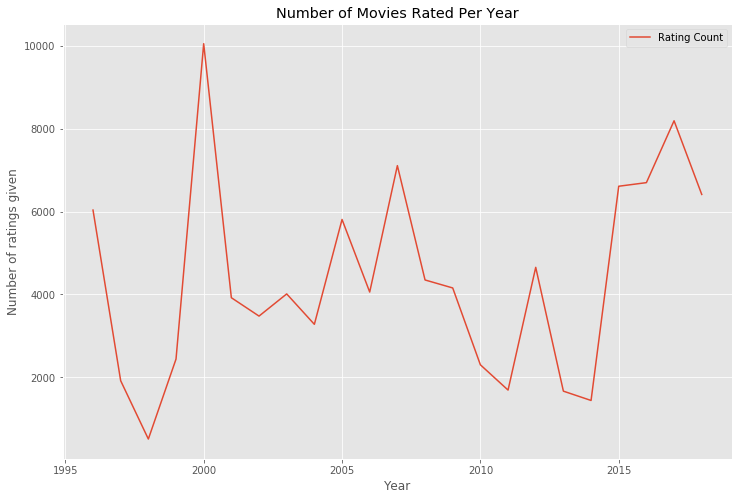

In [13]:
ratings_per_year = ratings[['rating', 'timestamp']].groupby('timestamp').count()
ratings_per_year.columns = ['Rating Count']
ax1 = ratings_per_year.plot(kind='line',figsize=(12,8))
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of ratings given')
plt.title('Number of Movies Rated Per Year')
plt.show()

### 1. Movies Released per Year

In [14]:
# Let's work with a temp smaller slice 'dftmp' of the original dataframe to reduce runtime (ratings hass +2MM rows)
dftmp = movies[['movieId', 'year']].groupby('year')
dftmp.head(10)

,movieId,year
0,1,1995.0
1,2,1995.0
2,3,1995.0
3,4,1995.0
4,5,1995.0
...,...,...
9669,183635,2018.0
9670,183897,2018.0
9671,183911,2018.0
9672,183959,2018.0


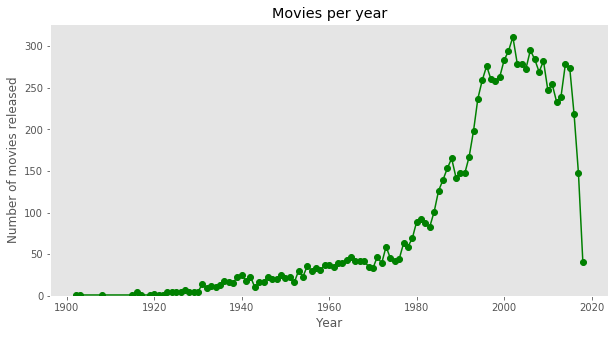

In [15]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released')
plt.title('Movies per year')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$)

<font color=darkblue>**PLOT#1**: Cumulative number of movies, in total </font><br/>
<font color=green>**INSIGHT#1**: Most Movies are released in between 1980 and 2020</font>

### 2. Ratings per Year

In [16]:
dftmp = ratings[['rating', 'timestamp']].groupby('timestamp')
dftmp.head(10)

,rating,timestamp
0,4.0,2000
1,5.0,1996
2,3.5,2006
3,3.0,2007
4,4.0,2006
...,...,...
1102,2.0,2011
1110,2.5,2014
1330,4.0,2013
1446,3.5,2014


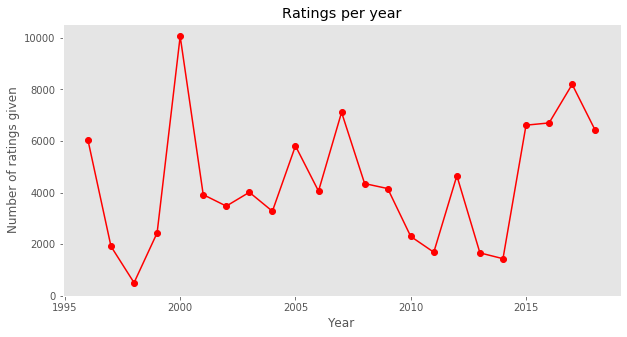

In [17]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax1.grid(None)
ax1.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of ratings given')
plt.title('Ratings per year')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$)

<font color=darkblue>**PLOT#2**: Number of Ratings Given Per Year </font><br/>
<font color=green>**INSIGHT#2**: Ratings given vary in different years.Most Ratings are given around year 2000</font>

### 3. Average Movie Rating

In [18]:
dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())
dftmp.head(10)

,year,rating
movieId,,
1,1995.0,3.920930
2,1995.0,3.431818
3,1995.0,3.259615
4,1995.0,2.357143
5,1995.0,3.071429
6,1995.0,3.946078
7,1995.0,3.185185
8,1995.0,2.875000
9,1995.0,3.125000


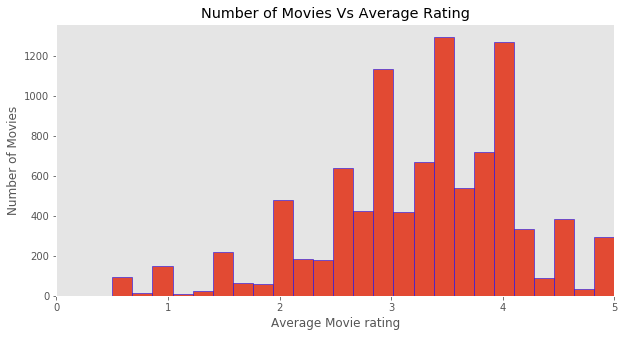

In [19]:
dftmp.rating.hist(bins=25, grid=False, edgecolor='b',figsize=(10,5))
plt.xlim(0,5)
plt.xlabel('Average Movie rating')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Vs Average Rating')
plt.show()
# Housekeeping
%reset_selective -f (^dftmp$)

<font color=darkblue>**PLOT#3**: Average Movie Ratings</font><br/>
<font color=green>**INSIGHT#3**: Average movie ratings creates normal distrubition peaked at about 3.5 </font>

### 4. Average Movie Ratings Per Year

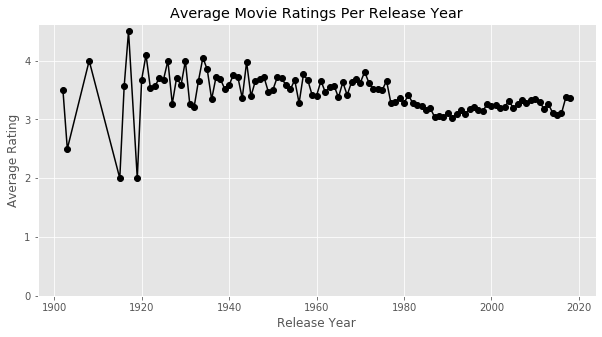

In [20]:
plt.figure(figsize=(10,5))

dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "r-o", label='All genres', color='black')

plt.xlabel('Release Year')
plt.ylabel('Average Rating')
plt.title('Average Movie Ratings Per Release Year')
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$)

<font color=darkblue>**PLOT#4**: Average Movie Ratings Per Year</font><br/>
<font color=green>**INSIGHT#4**: While movies released after 1960s have more stable average rating, old movies have huge variation in consecutive years </font>

### 5. Average Movie Ratings Per Year In Detail

In [21]:
first_rating_timestamp = ratings['timestamp'].min()
print("First Movie Released at",first_rating_timestamp)

First Movie Released at 1996


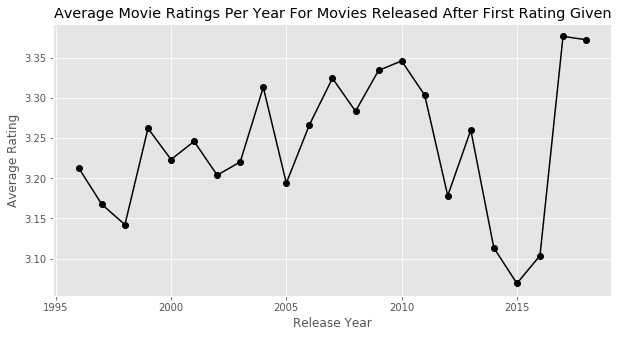

In [22]:
plt.figure(figsize=(10,5))

dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp[dftmp['year'] >= first_rating_timestamp]
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "r-o", label='All genres', color='black')

plt.xlabel('Release Year')
plt.ylabel('Average Rating')
plt.title('Average Movie Ratings Per Year For Movies Released After First Rating Given')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$)

<font color=darkblue>**PLOT#5**: Average Rating For Movies Released After First Rating Given</font><br/>
<font color=green>**INSIGHT#5**: Users bias changes in different years, as we can see in 2010 users gave average of 3.35 to movies and about 2.5 in 2015 </font><br/>
<font color=green>**INSIGHT#5.1**: When we take a closer look at the average rating of the movies that has been released after first rating given in the dataset, average ratings seem to change a lot as the years pass by. And, average ratings tend to go down. This raises questions like, does the movies released in adjacent years changes a lot, or the users having a different trend after the first trend and new movies that has been released on the adjacent years tend to be similar with old trend, which results in lower averages. </font>

### 6. Average Rating Per User

In [23]:
dftmp = ratings[['userId','rating']].groupby('userId').mean()
dftmp.head(10)

,rating
userId,
1,4.366379
2,3.948276
3,2.435897
4,3.555556
5,3.636364
6,3.493631
7,3.230263
8,3.574468
9,3.260870


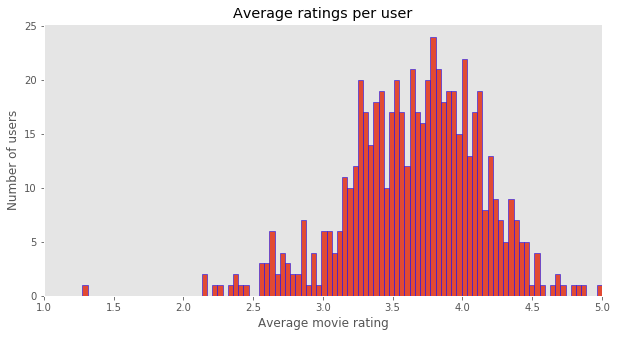

In [24]:
# Plot histogram
dftmp.rating.hist(bins=100, grid=False, edgecolor='b',figsize=(10,5))

plt.xlim(1,5)
plt.xlabel ('Average movie rating')
plt.ylabel ('Number of users')
plt.title ('Average ratings per user')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

<font color=darkblue>**PLOT#6**: Average Rating Per User</font><br/>
<font color=green>**INSIGHT#6**: Users on average gives 3.7 to movies but different users have different average which shows us some of the users are inclined to give low rating and some of them inclined to give high ratings. </font>

### 7. Ratings Per User

In [25]:
dftmp = ratings[['userId', 'movieId']].groupby('userId').count()
dftmp.columns=['num_ratings']
dftmp.sort_values(by='num_ratings', inplace=True, ascending=False)
dftmp.head(10)

,num_ratings
userId,
414,2698
599,2478
474,2108
448,1864
274,1346
610,1302
68,1260
380,1218
606,1115


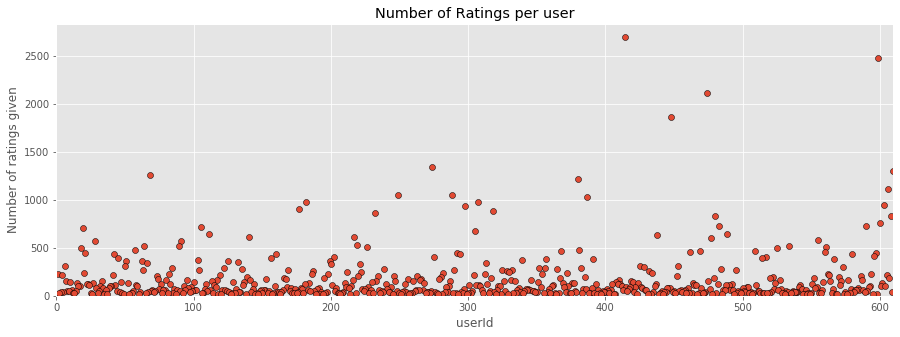

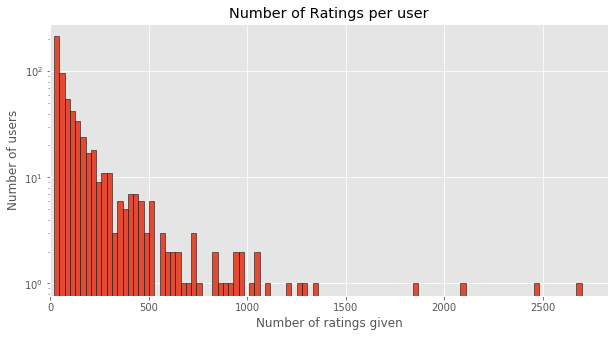

In [26]:
# Scatter plot of all users and individual ratings count.
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,len(dftmp.index))
plt.ylim(0,)
plt.title('Number of Ratings per user')
plt.xlabel('userId')
plt.ylabel('Number of ratings given')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(10,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Number of Ratings per user')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of users')
plt.xlim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

<font color=darkblue>**PLOT#7**: Number of Ratings Given Per User</font><br/>
<font color=green>**INSIGHT#7**: while high active users are tend to rate 200-500 movies, most of the users gave only few ratings almost 0. Dataset is quite sparse.  </font>

### 8. Rating Per Movie

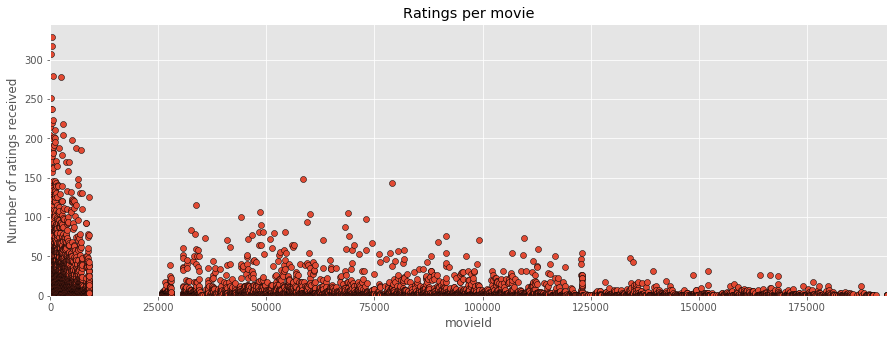

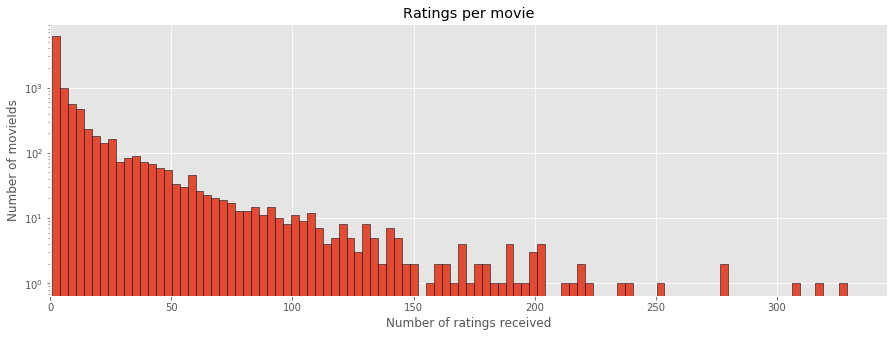

In [27]:
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()

<font color=darkblue>**PLOT#7**: Number of Ratings Received Per Movie</font><br/>
<font color=green>**INSIGHT#7**: Almost %99 percent of the movies taken less than 150 ratings.  </font>

In [28]:
# Let's check those movies with +150 reviews, those should be pretty popular movies!
movies.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>150]]['title']

movieId
1                                               Toy Story
32                     Twelve Monkeys (a.k.a. 12 Monkeys)
47                                   Seven (a.k.a. Se7en)
50                                    Usual Suspects, The
110                                            Braveheart
150                                             Apollo 13
260                    Star Wars: Episode IV - A New Hope
296                                          Pulp Fiction
318                             Shawshank Redemption, The
344                            Ace Ventura: Pet Detective
356                                          Forrest Gump
364                                        Lion King, The
367                                             Mask, The
377                                                 Speed
380                                             True Lies
457                                         Fugitive, The
480                                         Jurassic Park
527   

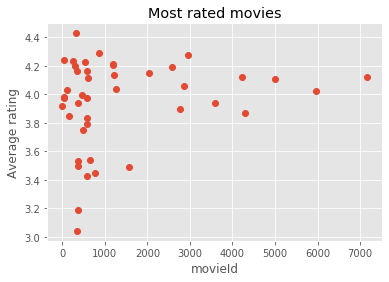

In [29]:
# Let's check the average rating too, those should be pretty good movies!
ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>150]].groupby('movieId').mean().rating.plot(style='o')
plt.ylabel('Average rating')
plt.title('Most rated movies')
plt.show()

<font color=darkblue>**PLOT#8**: Most Rated Movies</font><br/>
<font color=green>**INSIGHT#8**: Most rated movies also tend to be most liked movies.  </font>

In [30]:
# Which is the best most popular movie ever??
tmp = ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>100]].groupby('movieId').mean()
best = movies.set_index('movieId').loc[tmp.rating.idxmax].title
print ('Best most popular movie ever is...%s' %best)

Best most popular movie ever is...Shawshank Redemption, The


In [31]:
# Housekeeping
%reset_selective -f (^dftmp$|^tmp$|^best$)